# Adaptive gains
This script will see how the adaptive algorithm out-preforms the passive algorithm.

It does this by seeing how many rankings are considered the funniest ranking. For each caption we have a mean and a standard deviation. If the first rated caption has mean $\mu_1$ and std.dev. of $\sigma_1$, we want how many captions $i$ have $\mu_i + \sigma_i > \mu_1 - \sigma_1$.

### Metrics
* Number of "top captions"
* Mean/median rank of top $n$ captions (top captions from the end of the contest)

## Obtaining the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import utils

## Finding the mean and number of possible top captions 
Another implementation can be found in `/summary-stats/summary-stats-v2.py`.

In [2]:
def find_top_captions(df):
    i_top_mean = np.argmax(df['score'].values)#idxmax(skipna=True)
    top_caption = df.iloc[i_top_mean]
    min_rating = top_caption['score'] - top_caption['precision']
    df['upper bound'] = df['score'] + df['precision']
    
    return (df['upper bound'] > min_rating).sum(), top_caption['score'], top_caption['precision']

In [105]:
def iteration_stats(ratings, truth=None, n_top_captions={'truth': 150, 'responses': 10}):
    """
    Parameters
    ----------
    top_captions
        The number of captions to consider "top"
        truth: used in prob response['caption'] in truth[:top_captions['truth']]
        responses: number of captions to consider
    """
    ratings = utils.calculate_stats(ratings)
    top_captions, top_mean, top_prec = find_top_captions(ratings) 
    ret = {'top_captions': top_captions, 'top_mean': top_mean, 'top_precision': top_prec}
    
    if truth is not None:
        top = truth[truth['rank'] <= n_top_captions['responses']]
        
        scores = [truth[truth['target_id'] == target_id]['rank'].values
                  for target_id in top['target_id']]
        scores = np.array([score for score in scores if len(score) > 0])
        
        probs = []
        for target_id in top['target_id']:
            condition = truth['target_id'] == target_id
            if sum(condition) == 0:
                probs += [0]
                continue
            assert sum(condition) == 1
            caption = truth[condition] 
            probs += [1.0 if caption['rank'].values[0] <= n_top_captions['truth'] else 0.0]
            
        ret.update({'scores_in_random': scores.sum(),
                    'n_top_captions_truth': n_top_captions['truth'],
                    'n_top_captions_responses': n_top_captions['responses'],
                    'prob_in_random_top': sum(probs) / len(probs) if len(probs) > 0 else 0,
                   })
        
    return ret

## Initializing responses
These are the variables we will count the responses in

## Replaying one contest 

In [106]:
def add_response(summary, response, mapping={1.0: 'unfunny', 2.0: 'somewhat_funny', 3.0: 'funny'}):
    i = np.argwhere(summary['target_id'] == response['target_id']).flat[0]
    reward = mapping[response['target_reward']]
    summary.loc[i, reward] += 1
    summary.loc[i, 'count'] += 1
    return summary

In [107]:
import sys

def replay_contest(df, verbose=True, **kwargs):
    """
    Replay the contest. Find and record stats at certain intervals
    
    Parameters
    ----------
    df : pd.DataFrame
        Responses to the contest (not necessarily sorted) 
        
    Returns
    -------
    performance : pd.DataFrame
       includes fields of algorithm, responses, (possible) top captions 
       
    """
    df = df.sort_values(by='timestamp_query_generated')
    n_captions = len(df['target_id'].unique())
    ratings = {alg: utils.init_summary(df) for alg in df['alg_label'].unique()}
    performance = [] 
    
    j = 0
    for _, response in df.iterrows():
        if j > 2:
            assert last_response['timestamp_query_generated'] <= response['timestamp_query_generated']
            
        alg_label = response['alg_label']
        ratings[alg_label] = add_response(ratings[alg_label], response)
        
        n_responses = ratings[alg_label]['count'].sum()
        if n_responses % n_captions == 0 and n_responses >= n_captions:
            if verbose:
                print('Number of epochs = {}, total_fraction = {}'.format(j / n_captions, j / len(df)))
            stats = iteration_stats(ratings[alg_label], **kwargs)
            datum = {'responses': n_responses,
                     'algorithm': alg_label,
                     'n_captions': n_captions}
            datum.update(stats)
            performance += [datum]
            
        last_response = response
        j += 1
    performance = pd.DataFrame(performance)
    return performance

In [108]:
def one_contest_results(contest, **kwargs):
    return df

In [109]:
contest = '559-active'
responses = utils.read_responses('{}-responses.csv.zip'.format(contest))
truth = utils.read_summary('559_summary_RandomSamping.csv')
truth = utils.add_target_ids(truth, responses)
print('...done loading data')

...done loading data


In [110]:
kwargs = {'truth': truth}
df = replay_contest(responses, **kwargs)
df['contest'] = contest

Number of epochs = 1.9702713487629688, total_fraction = 0.01975537346158155
Number of epochs = 2.031923383878691, total_fraction = 0.0203735416033161
Number of epochs = 3.9694732641660018, total_fraction = 0.0398008258246243
Number of epochs = 4.02952913008779, total_fraction = 0.04040298961317478
Number of epochs = 5.9351556264964085, total_fraction = 0.05951018677080166
Number of epochs = 6.056464485235435, total_fraction = 0.06072651761279068
Number of epochs = 7.928371907422187, total_fraction = 0.07949562280940416
Number of epochs = 8.074820430965682, total_fraction = 0.08096402221404222
Number of epochs = 9.929169992019155, total_fraction = 0.09955707952563098
Number of epochs = 10.071827613727056, total_fraction = 0.10098746859145688
Number of epochs = 11.90582601755786, total_fraction = 0.11937647039994878
Number of epochs = 12.091580207501995, total_fraction = 0.12123897700174448
Number of epochs = 13.91001596169194, total_fraction = 0.13947193636669175
Number of epochs = 14.0

In [111]:
df.head()

,algorithm,n_captions,n_top_captions_responses,n_top_captions_truth,prob_in_random_top,responses,scores_in_random,top_captions,top_mean,top_precision,contest
0,KLUCB,5012,10,150,1.0,5012.0,55,0,NaN,NaN,559-active
1,LilUCB,5012,10,150,1.0,5012.0,55,0,NaN,NaN,559-active
2,KLUCB,5012,10,150,1.0,10024.0,55,4585,2.000000,0.308607,559-active
3,LilUCB,5012,10,150,1.0,10024.0,55,5012,2.000000,1.000000,559-active
4,KLUCB,5012,10,150,1.0,15036.0,55,1776,1.818182,0.226362,559-active


## Visualization
This means that LilUCB saw ~10 captions that could be the funniest, and RoundRobin saw ~50 captions that could be the funniest. 

This visualization tries to normalize for different number of captions received in each contest by

* plotting for "epochs", or `epochs = questions_received_for_alg / total_captions`. 
* plotting the score as the percentage of "winning" captions.
* "winning captions" is defined to be number of captions that fall who has a mean within one std.dev of top caption. 

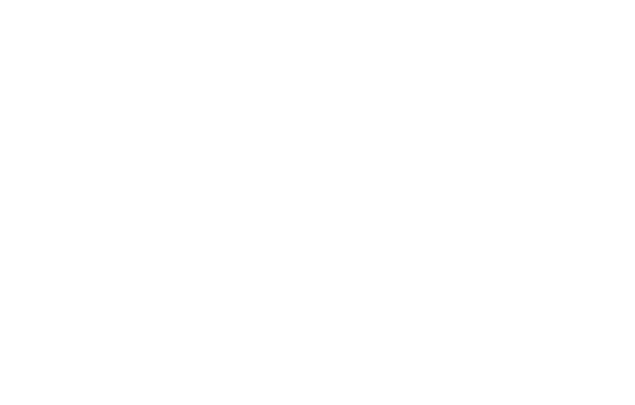

In [117]:
from altair import Chart, Y, Scale, X

Chart(df).mark_line().encode(
    x=X('responses', scale=Scale(type='linear')),
    y=Y('top_captions', scale=Scale(type='log')),
    color='algorithm')

We see that the the adaptive algorithm provides benefits after ~17 epochs. 

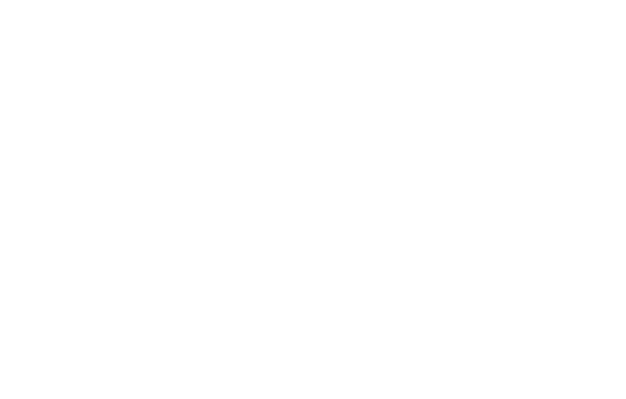

In [113]:
Chart(df).mark_line().encode(
    x=X('responses', scale=Scale(type='linear')),
    y=Y('prob_in_random_top', scale=Scale(type='log')),
    color='algorithm')

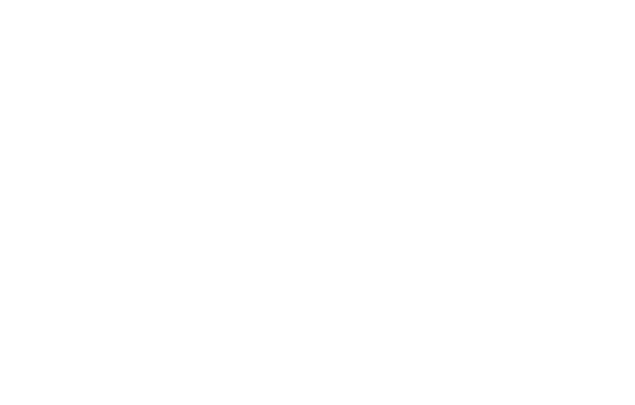

In [114]:
Chart(df).mark_line().encode(
    x=X('responses', scale=Scale(type='linear')),
    y=Y('scores_in_random', scale=Scale(type='log')),
    color='algorithm')

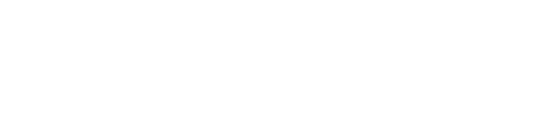

In [115]:
Chart(df).mark_circle().encode(
    x='responses', y=Y('count(contest)', sort='descending')
)